# Makes analysis to compare yearly inflow into aral sea

TODO: conversion error: HBV mm/day -> m3/s

In [120]:
from ewatercycle.observation.grdc import get_grdc_data
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from cartopy import crs
from cartopy import feature as cfeature
import matplotlib.colors as mcolors

import fiona
import shapely.geometry
from pyproj import Geod

In [121]:
grdc_chatly = get_grdc_data(2817100,
                   '1900-01-01T00:00Z',
                   '2001-01-01T00:00Z',
                   data_home='/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in_progress/Test_Aral/')

results_hbv = pd.read_csv(
    "/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in_progress/Test_Aral/HBV_AralBasin_5000.csv",
    index_col=0,          # use first column as index
    parse_dates=True      # automatically parse as datetime if possible
)

results_CMIP = pd.read_csv(
    "/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in_progress/Comparison/Reference_CMIP_5570.csv",
    parse_dates=["time"],   # make sure 'time' is parsed as datetime
    index_col="time"
)

In [122]:
results_CMIP

,Chatly,Kerki,Tyumen,Kazalinsk,Dushanbe
time,,,,,
1955-01-01 00:00:00+00:00,963.286743,653.683899,514.703918,663.610413,0.000000
1955-01-02 00:00:00+00:00,558.165527,1159.793091,547.146362,659.156738,0.000000
1955-01-03 00:00:00+00:00,539.615356,911.676697,606.900391,691.221863,0.000000
1955-01-04 00:00:00+00:00,507.370453,2045.225220,1136.786011,646.026306,0.000000
1955-01-05 00:00:00+00:00,456.309875,97107.125000,25333.593750,572.949890,0.000000
...,...,...,...,...,...
1970-12-27 00:00:00+00:00,2591.685303,513.604187,1261.662354,1939.670410,0.537049
1970-12-28 00:00:00+00:00,3258.230713,491.660278,1166.149414,1641.803101,0.536134
1970-12-29 00:00:00+00:00,3955.073242,478.063049,1121.013672,2057.717773,0.537060


In [123]:
conversion_mmday2m3s = 1 / (1000 * 86400)
shape = fiona.open('/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in_progress/Test_Aral/AralSea_Basin/AralSeaBasin.shp')
poly = [shapely.geometry.shape(p["geometry"]) for p in shape][0]
geod = Geod(ellps="WGS84")
poly_area, poly_perimeter = geod.geometry_area_perimeter(poly)
catchment_area_m2 = abs(poly_area)
print(f"{catchment_area_m2 = }")

results_hbv['Modelled_discharge'] = results_hbv['Modelled_discharge']* conversion_mmday2m3s * catchment_area_m2

results_hbv.head()

catchment_area_m2 = 1845542301721.4697


,Modelled_discharge
1950-01-02 12:00:00,10.650598
1950-01-03 12:00:00,43.200426
1950-01-04 12:00:00,98.837183
1950-01-05 12:00:00,178.731854
1950-01-06 12:00:00,262.735916


In [124]:
seconds_per_day = 24*60*60
Q1 = grdc_chatly['streamflow']
Q2 = results_hbv['Modelled_discharge']

Q2 = xr.DataArray(
    results_hbv["Modelled_discharge"].values,
    dims=["time"],
    coords={"time": pd.to_datetime(results_hbv.index)},
    name="Modelled_discharge"
)


Q3 = results_CMIP.to_xarray()
Q3['time'] = pd.to_datetime(Q3['time'].values)


In [125]:
Q3

<xarray.Dataset> Size: 281kB
Dimensions:    (time: 5844)
Coordinates:
  * time       (time) datetime64[ns] 47kB 1955-01-01 1955-01-02 ... 1970-12-31
Data variables:
    Chatly     (time) float64 47kB 963.3 558.2 539.6 ... 3.007e+03 1.523e+03
    Kerki      (time) float64 47kB 653.7 1.16e+03 911.7 ... 478.1 479.8 546.4
    Tyumen     (time) float64 47kB 514.7 547.1 606.9 ... 1.068e+03 1.031e+03
    Kazalinsk  (time) float64 47kB 663.6 659.2 691.2 ... 2.166e+03 1.836e+03
    Dushanbe   (time) float64 47kB 0.0 0.0 0.0 0.0 ... 0.5371 0.535 0.5359

In [128]:
Q2

<xarray.DataArray 'Modelled_discharge' (time: 18627)> Size: 149kB
array([  10.65059845,   43.20042598,   98.83718342, ..., 1117.22877048,
       1114.25371387, 1111.49766762])
Coordinates:
  * time     (time) datetime64[ns] 149kB 1950-01-02T12:00:00 ... 2000-12-31T1...

In [126]:
V1_yearly = (Q1 * seconds_per_day).resample(time="YE").sum()
V2_yearly = (Q2 * seconds_per_day).resample(time="YE").sum()
V3_yearly = (Q3 * seconds_per_day).resample(time="YE").sum()

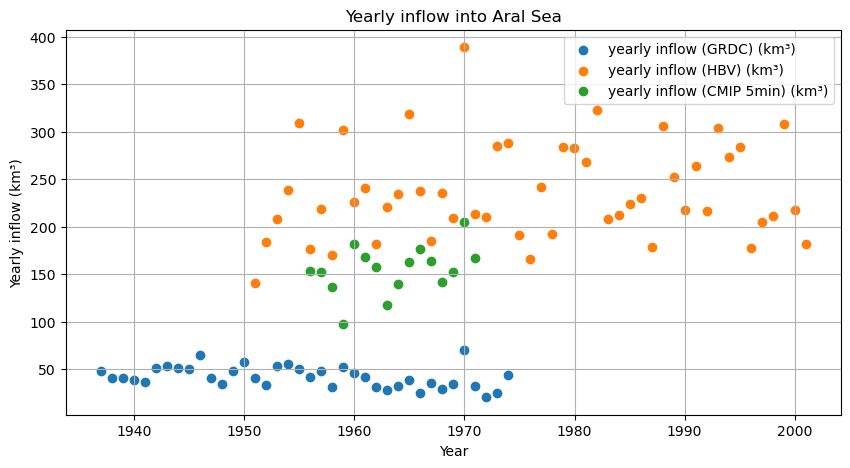

In [131]:
plt.figure(figsize=(10,5))
plt.scatter(V1_yearly.time, V1_yearly/1e9, label='yearly inflow (GRDC) (km³)')
plt.scatter(V2_yearly.time, V2_yearly/1e9, label='yearly inflow (HBV) (km³)')
plt.scatter(V3_yearly.time, V3_yearly['Chatly']/1e9, label='yearly inflow (CMIP 5min) (km³)')
plt.xlabel('Year')
plt.ylabel('Yearly inflow (km³)')
plt.grid()
plt.title('Yearly inflow into Aral Sea')
plt.legend()
plt.show()   

In [139]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# Open dataset
url = "https://opendap.4tu.nl/thredds/dodsC/data2/pcrglobwb/version_2019_11_beta/pcrglobwb2_input/global_05min/waterUse/abstraction_zones/abstraction_zones_60min_05min.nc"
ds = xr.open_dataset(url)
abstraction = ds['abstraction_zones_60min_05min_map']

# Convert to integer if the zones are categorical
abstraction_int = abstraction.astype(int)

# Plot
plt.figure(figsize=(14,6))
cmap = plt.get_cmap('tab20', np.unique(abstraction_int).size)  # discrete colormap
im = plt.imshow(abstraction_int, origin='upper', cmap=cmap,
                extent=[abstraction.lon.min(), abstraction.lon.max(),
                        abstraction.lat.min(), abstraction.lat.max()])
plt.colorbar(im, ticks=np.unique(abstraction_int), label='Abstraction Zone ID')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Abstraction Zones 60min->5min')
plt.show()

RuntimeError: NetCDF: DAP failure